# ROBERTA Model for the Evaluation Framework

## Import of packages 

In [1]:
import pandas as pd
import transformers
import numpy as np
from tqdm import tqdm
from sklearn import metrics
import torch
import logging
import warnings

from torch import cuda

In [2]:
%reload_ext watermark
%watermark -v -p numpy,pandas,torch,transformers

Python implementation: CPython
Python version       : 3.7.10
IPython version      : 7.20.0

numpy       : 1.19.2
pandas      : 1.2.2
torch       : 1.8.1+cu111
transformers: 4.4.2



In [3]:
device = 'cuda' if cuda.is_available() else 'cpu'

device

if device == 'cuda':
    gpu_server = True # in case we run the notebook on Colab, set it to False

In [4]:
if gpu_server == True:
    semcor_df    = pd.read_csv('data/semcor_df.csv'   )
    semeval_2007 = pd.read_csv('data/semeval_2007.csv')
    semeval_2013 = pd.read_csv('data/semeval_2013.csv')
    semeval_2015 = pd.read_csv('data/semeval_2015.csv')
    senseval_2   = pd.read_csv('data/senseval_2.csv'  )
    senseval_3   = pd.read_csv('data/senseval_3.csv'  )
else:
    semcor_df    = pd.read_csv('/content/drive/MyDrive/semcor_belli/semcor_df.csv'   )
    semeval_2007 = pd.read_csv('/content/drive/MyDrive/semcor_belli/semeval_2007.csv')
    semeval_2013 = pd.read_csv('/content/drive/MyDrive/semcor_belli/semeval_2013.csv')
    semeval_2015 = pd.read_csv('/content/drive/MyDrive/semcor_belli/semeval_2015.csv')
    senseval_2   = pd.read_csv('/content/drive/MyDrive/semcor_belli/senseval_2.csv'  )
    senseval_3   = pd.read_csv('/content/drive/MyDrive/semcor_belli/senseval_3.csv'  )

## Preparation of Training Data: SEMCOR

In [5]:
semcor_df.head()

,Unnamed: 0,text|@id,text|sentence|@id,text|sentence|instance,text|sentence|instance|@id,text|sentence|instance|@lemma,text|sentence|instance|@pos,lexelt|sense|@id,lexelt|@item,lexelt|@pos,lexelt|@sence_count_wn,lexelt|@sense_count_corpus,lexelt|@word_example_count,lexelt|sense|@gloss,lexelt|sense|@sense_example_count,lexelt|sense|@sense_freq,lexelt|sense|@synset,sentences
0,0,d000,d000.s000,long,d000.s000.t000,long,ADJ,long%3:00:02::,long#a,a,9,3,193,primarily temporal sense; being or indicating ...,102,118,long,How long has it been since you reviewed the ob...
1,1,d000,d000.s000,been,d000.s000.t001,be,VERB,be%2:42:03::,be#v,v,13,11,15783,"have the quality of being; (copula, used with ...",10088,10742,be,How long has it been since you reviewed the ob...
2,2,d000,d000.s000,reviewed,d000.s000.t002,review,VERB,review%2:31:00::,review#v,v,5,3,22,look at again; examine again,12,13,review reexamine,How long has it been since you reviewed the ob...
3,3,d000,d000.s000,objectives,d000.s000.t003,objective,NOUN,objective%1:09:00::,objective#n,n,2,1,38,the goal intended to be attained (and which is...,38,38,aim object objective target,How long has it been since you reviewed the ob...
4,4,d000,d000.s000,benefit,d000.s000.t004,benefit,NOUN,benefit%1:21:00::,benefit#n,n,3,3,31,financial assistance in time of need,16,16,benefit,How long has it been since you reviewed the ob...


In [6]:
semcor_df.shape

(225380, 18)

In [7]:
check = semcor_df['text|sentence|instance|@pos'].value_counts()
check

VERB    88098
NOUN    86668
ADJ     31673
ADV     18941
Name: text|sentence|instance|@pos, dtype: int64

In [8]:
semcor_df = semcor_df.drop(semcor_df[semcor_df['text|sentence|instance|@pos'] == 'VERB'].index)
semcor_df = semcor_df.drop(semcor_df[semcor_df['text|sentence|instance|@pos'] == 'ADJ'].index)
semcor_df = semcor_df.drop(semcor_df[semcor_df['text|sentence|instance|@pos'] == 'ADV'].index)

In [9]:
semcor_df.shape

(86668, 18)

In [10]:
semcor_df1 = semcor_df.drop(['Unnamed: 0','text|@id','text|sentence|@id','text|sentence|instance',
                             'text|sentence|instance|@pos','lexelt|@item','lexelt|@pos','lexelt|@sence_count_wn',
                             'lexelt|@sense_count_corpus','lexelt|@word_example_count','lexelt|sense|@gloss',
                             'lexelt|sense|@sense_example_count','lexelt|sense|@sense_freq','lexelt|sense|@synset'],
                  axis=1)
semcor_df1

,text|sentence|instance|@id,text|sentence|instance|@lemma,lexelt|sense|@id,sentences
3,d000.s000.t003,objective,objective%1:09:00::,How long has it been since you reviewed the ob...
4,d000.s000.t004,benefit,benefit%1:21:00::,How long has it been since you reviewed the ob...
5,d000.s000.t005,service,service%1:04:07::,How long has it been since you reviewed the ob...
6,d000.s000.t006,program,program%1:09:01::,How long has it been since you reviewed the ob...
9,d000.s001.t002,giveaway,giveaway%1:21:00::,Have you permitted it to become a giveaway pro...
...,...,...,...,...
220309,d183.s068.t000,person,person%1:03:00::,Kate 's all right''.
220310,d183.s088.t000,vacation,vacation%1:28:00::,"Well, we 're taking a little vacation, that 's..."
220314,d183.s138.t000,person,person%1:03:00::,`` How 's Scotty''?
220315,d185.s034.t000,plunker,plunker%1:04:00::,No plunkers for him''.


In [11]:
df2 = semcor_df1.rename(columns = {'lexelt|sense|@id': 'target'})
df2.head()

,text|sentence|instance|@id,text|sentence|instance|@lemma,target,sentences
3,d000.s000.t003,objective,objective%1:09:00::,How long has it been since you reviewed the ob...
4,d000.s000.t004,benefit,benefit%1:21:00::,How long has it been since you reviewed the ob...
5,d000.s000.t005,service,service%1:04:07::,How long has it been since you reviewed the ob...
6,d000.s000.t006,program,program%1:09:01::,How long has it been since you reviewed the ob...
9,d000.s001.t002,giveaway,giveaway%1:21:00::,Have you permitted it to become a giveaway pro...


In [12]:
df2 = df2.reset_index(drop=True)

In [13]:
item_counts = df2["target"].value_counts()
item_counts

person%1:03:00::           6696
group%1:03:00::            1328
location%1:03:00::          989
man%1:18:00::               429
year%1:28:01::              409
                           ... 
frustration%1:04:02::         1
nobel_prize%1:10:00::         1
thinness%1:07:00::            1
de-iodination%1:22:00::       1
brick%1:18:00::               1
Name: target, Length: 15875, dtype: int64

In [14]:
df2.isna().sum() 

text|sentence|instance|@id       0
text|sentence|instance|@lemma    0
target                           0
sentences                        0
dtype: int64

In [15]:
df2.dtypes

text|sentence|instance|@id       object
text|sentence|instance|@lemma    object
target                           object
sentences                        object
dtype: object

In [16]:
df2["target"] = df2["target"].astype('category')
df2.dtypes

text|sentence|instance|@id         object
text|sentence|instance|@lemma      object
target                           category
sentences                          object
dtype: object

In [17]:
#df2["target_enc"] = df2["target"].cat.codes
#df2.head()

In [18]:
new_data = pd.DataFrame()
new_data['sentences'] = df2['sentences']
new_data['target'] = df2['target']
new_data['dataset'] = 'training'

#new_data = pd.DataFrame()
#new_data['text'] = df2['sentences']
#new_data['labels'] = df2['target_enc']

In [19]:
new_data.head()

,sentences,target,dataset
0,How long has it been since you reviewed the ob...,objective%1:09:00::,training
1,How long has it been since you reviewed the ob...,benefit%1:21:00::,training
2,How long has it been since you reviewed the ob...,service%1:04:07::,training
3,How long has it been since you reviewed the ob...,program%1:09:01::,training
4,Have you permitted it to become a giveaway pro...,giveaway%1:21:00::,training


<AxesSubplot:>

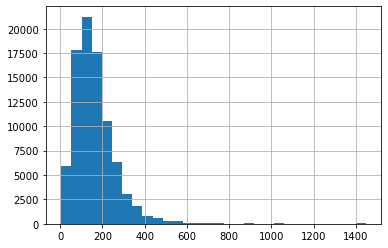

In [20]:
sentences = [len(sent) for sent in new_data['sentences']]
pd.Series(sentences).hist(bins=30)

## Preparation of Validation Data: Semeval & Senseval

In [21]:
semeval_2007.shape,semeval_2013.shape,semeval_2015.shape,senseval_2.shape,senseval_3.shape

((455, 7), (1644, 7), (1022, 7), (2282, 7), (1850, 7))

In [22]:
semeval_2007 = semeval_2007.drop(['Unnamed: 0','text|lemma|@id','text|sentence|@id'],axis=1)
semeval_2007

,lemma,pos,sentences,lexelt|sense|@id
0,refer,VERB,Your Oct. 6 editorial`` The Ill Homeless`` ref...,refer%2:32:01::
1,research,NOUN,Your Oct. 6 editorial`` The Ill Homeless`` ref...,research%1:04:00::
2,report,VERB,Your Oct. 6 editorial`` The Ill Homeless`` ref...,report%2:32:04::
3,comment,NOUN,Your comments implied we had discovered that t...,comment%1:10:00::
4,imply,VERB,Your comments implied we had discovered that t...,imply%2:32:00::
...,...,...,...,...
450,ride,VERB,My American companion and I were left to ride ...,ride%2:38:00::
451,streak,VERB,"As we streaked by a blase gendarme, I could n'...",streak%2:38:00::
452,resist,VERB,"As we streaked by a blase gendarme, I could n'...",resist%2:33:00::
453,rear,VERB,"As we streaked by a blase gendarme, I could n'...",rear%2:38:00::


In [23]:
semeval_2013 = semeval_2013.drop(['Unnamed: 0','text|lemma|@id','text|sentence|@id'],axis=1)
semeval_2013

,lemma,pos,sentences,lexelt|sense|@id
0,group,NOUN,U.N. group drafts plan to reduce emissions,group%1:03:00::
1,plan,NOUN,U.N. group drafts plan to reduce emissions,plan%1:09:00::
2,emission,NOUN,U.N. group drafts plan to reduce emissions,emission%1:27:00::
3,climate,NOUN,The U.N.-sponsored climate conference-- charac...,climate%1:26:00::
4,conference,NOUN,The U.N.-sponsored climate conference-- charac...,conference%1:14:00::
...,...,...,...,...
1639,loss,NOUN,The regulator is demanding that the Frankfurt-...,loss%1:21:01::
1640,sum,NOUN,The regulator is demanding that the Frankfurt-...,sum%1:21:00::
1641,claim,NOUN,Deutsche Bank has rejected the claims as basel...,claim%1:10:02::
1642,intention,NOUN,Deutsche Bank has rejected the claims as basel...,intention%1:09:00::


In [24]:
semeval_2015 = semeval_2015.drop(['Unnamed: 0','text|lemma|@id','text|sentence|@id'],axis=1)
semeval_2015

,lemma,pos,sentences,lexelt|sense|@id
0,document,NOUN,This document is a summary of the European Pub...,document%1:10:00::
1,summary,NOUN,This document is a summary of the European Pub...,summary%1:10:00::
2,european,ADJ,This document is a summary of the European Pub...,european%3:01:00::
3,public,ADJ,This document is a summary of the European Pub...,public%3:00:00::
4,assessment,NOUN,This document is a summary of the European Pub...,assessment%1:04:00::
...,...,...,...,...
1017,not,ADV,Cerenia does not represent a particular risk f...,not%4:02:00::
1018,represent,VERB,Cerenia does not represent a particular risk f...,represent%2:42:00::
1019,particular,ADJ,Cerenia does not represent a particular risk f...,particular%5:00:00:uncommon:00
1020,risk,NOUN,Cerenia does not represent a particular risk f...,risk%1:26:00::


In [25]:
senseval_2 = senseval_2.drop(['Unnamed: 0','text|lemma|@id','text|sentence|@id'],axis=1)
senseval_2

,lemma,pos,sentences,lexelt|sense|@id
0,art,NOUN,The art of change-ringing is peculiar to the E...,art%1:09:00::
1,change_ringing,NOUN,The art of change-ringing is peculiar to the E...,change_ringing%1:04:00::
2,peculiar,ADJ,The art of change-ringing is peculiar to the E...,peculiar%5:00:00:specific:00
3,english,NOUN,The art of change-ringing is peculiar to the E...,english%1:18:00::
4,most,ADJ,The art of change-ringing is peculiar to the E...,most%3:00:02::
...,...,...,...,...
2277,fact,NOUN,"This is a fact-- though, in view of all the fe...",fact%1:09:01::
2278,surprising,ADJ,"This is a fact-- though, in view of all the fe...",surprising%3:00:00::
2279,one,NOUN,"This is a fact-- though, in view of all the fe...",one%1:09:00::
2280,so,ADV,"This is a fact-- though, in view of all the fe...",so%4:02:02::


In [26]:
senseval_3 = senseval_3.drop(['Unnamed: 0','text|lemma|@id','text|sentence|@id'],axis=1)
senseval_3

,lemma,pos,sentences,lexelt|sense|@id
0,man,NOUN,That 's what the man had said.,man%1:18:00::
1,say,VERB,That 's what the man had said.,say%2:32:01::
2,peer,VERB,Haney peered doubtfully at his drinking compan...,peer%2:39:00::
3,companion,NOUN,Haney peered doubtfully at his drinking compan...,companion%1:18:00::
4,bleary,ADJ,Haney peered doubtfully at his drinking compan...,bleary%5:00:00:indistinct:00
...,...,...,...,...
1845,smile,VERB,"Next to Chez Panisse a homeless couple, bundle...",smile%2:29:00::
1846,say,VERB,"Next to Chez Panisse a homeless couple, bundle...",say%2:32:00::
1847,great,ADJ,"Next to Chez Panisse a homeless couple, bundle...",great%5:00:00:good:01
1848,alive,ADJ,"Next to Chez Panisse a homeless couple, bundle...",alive%3:00:01::


In [27]:
sem_df = pd.concat([semeval_2007, semeval_2013, semeval_2015], ignore_index=True)

In [28]:
sens_df = pd.concat([senseval_2, senseval_3], ignore_index=True)

In [29]:
#455+1644+1022#+2282+1850

In [30]:
#2282+1850 #455+1644+1022

In [31]:
#2282+1850+455+1644+1022

In [32]:
eval_df = pd.concat([sem_df, sens_df], ignore_index=True)

In [33]:
sem_df.shape, sens_df.shape, eval_df.shape

((3121, 4), (4132, 4), (7253, 4))

In [34]:
item_counts = eval_df["lexelt|sense|@id"].value_counts()
item_counts #3520

cancer%1:26:00::       61
gene%1:08:00::         60
year%1:28:01::         36
use%2:34:01::          34
other%3:00:00::        32
                       ..
plumber%1:18:00::       1
battle%1:04:02::        1
new_york%1:15:01::      1
reporting%1:10:00::     1
violence%1:26:00::      1
Name: lexelt|sense|@id, Length: 3520, dtype: int64

In [35]:
eval_df.isna().sum() 

lemma               0
pos                 0
sentences           0
lexelt|sense|@id    0
dtype: int64

In [36]:
eval_df["target"] = eval_df["lexelt|sense|@id"].astype('category')
eval_df.dtypes

lemma                 object
pos                   object
sentences             object
lexelt|sense|@id      object
target              category
dtype: object

In [37]:
#eval_df["target_enc"] = eval_df["target"].cat.codes
#eval_df.head()

In [38]:
check = eval_df['pos'].value_counts()
check

NOUN    4300
VERB    1652
ADJ      955
ADV      346
Name: pos, dtype: int64

In [39]:
eval_df = eval_df.drop(eval_df[eval_df['pos'] == 'VERB'].index)
eval_df = eval_df.drop(eval_df[eval_df['pos'] == 'ADJ'].index)
eval_df = eval_df.drop(eval_df[eval_df['pos'] == 'ADV'].index)

In [40]:
check_classes = eval_df['lexelt|sense|@id'].value_counts()
check_classes

cancer%1:26:00::        61
gene%1:08:00::          60
year%1:28:01::          36
ringer%1:18:02::        27
country%1:14:00::       26
                        ..
mortgage%1:21:00::       1
proportion%1:24:00::     1
paradox%1:10:00::        1
bell_tower%1:06:00::     1
violence%1:26:00::       1
Name: lexelt|sense|@id, Length: 1881, dtype: int64

In [41]:
eval_df.shape

(4300, 5)

In [42]:
eval_df

,lemma,pos,sentences,lexelt|sense|@id,target
1,research,NOUN,Your Oct. 6 editorial`` The Ill Homeless`` ref...,research%1:04:00::,research%1:04:00::
3,comment,NOUN,Your comments implied we had discovered that t...,comment%1:10:00::,comment%1:10:00::
6,cause,NOUN,Your comments implied we had discovered that t...,cause%1:11:00::,cause%1:11:00::
9,statement,NOUN,We have made no such statement.,statement%1:10:06::,statement%1:10:06::
11,cause,NOUN,The`` causes`` of homelessness are poorly unde...,cause%1:11:00::,cause%1:11:00::
...,...,...,...,...,...
7237,morning,NOUN,I walked along Shattuck between Delaware and C...,morning%1:28:00::,morning%1:28:00::
7240,couple,NOUN,"Next to Chez Panisse a homeless couple, bundle...",couple%1:14:00::,couple%1:14:00::
7243,sleeping_bag,NOUN,"Next to Chez Panisse a homeless couple, bundle...",sleeping_bag%1:06:00::,sleeping_bag%1:06:00::
7246,good_morning,NOUN,"Next to Chez Panisse a homeless couple, bundle...",good_morning%1:10:00::,good_morning%1:10:00::


In [43]:
val_data = pd.DataFrame()
val_data['sentences'] = eval_df['sentences']
val_data['target'] = eval_df['target']
val_data['dataset'] = 'evaluation'

In [44]:
val_data.head()

,sentences,target,dataset
1,Your Oct. 6 editorial`` The Ill Homeless`` ref...,research%1:04:00::,evaluation
3,Your comments implied we had discovered that t...,comment%1:10:00::,evaluation
6,Your comments implied we had discovered that t...,cause%1:11:00::,evaluation
9,We have made no such statement.,statement%1:10:06::,evaluation
11,The`` causes`` of homelessness are poorly unde...,cause%1:11:00::,evaluation


<AxesSubplot:>

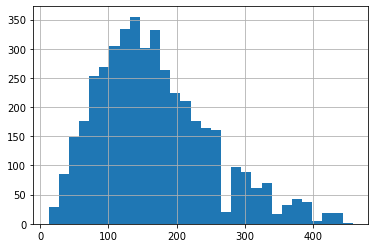

In [45]:
sentences = [len(sent) for sent in val_data['sentences']]
pd.Series(sentences).hist(bins=30)

## Union and encoding of variables

In [46]:
dataset = pd.concat([new_data, val_data], ignore_index=True)

In [47]:
dataset.shape, new_data.shape, val_data.shape

((90968, 3), (86668, 3), (4300, 3))

In [48]:
dataset["target_cat"] = dataset["target"].astype('category')
dataset.dtypes

sentences       object
target          object
dataset         object
target_cat    category
dtype: object

In [49]:
dataset["target_enc"] = dataset["target_cat"].cat.codes
dataset.head()

,sentences,target,dataset,target_cat,target_enc
0,How long has it been since you reviewed the ob...,objective%1:09:00::,training,objective%1:09:00::,9714
1,How long has it been since you reviewed the ob...,benefit%1:21:00::,training,benefit%1:21:00::,1292
2,How long has it been since you reviewed the ob...,service%1:04:07::,training,service%1:04:07::,12945
3,How long has it been since you reviewed the ob...,program%1:09:01::,training,program%1:09:01::,11244
4,Have you permitted it to become a giveaway pro...,giveaway%1:21:00::,training,giveaway%1:21:00::,6131


In [50]:
print(dataset['target_enc'].max())

16355


In [51]:
#is_train =  dataset['dataset']=='training'
#is_val   =  dataset['dataset']=='evaluation'

In [52]:
#train_data = dataset[is_train]
#eval_data  = dataset[is_val]

In [53]:
#train_data.shape, eval_data.shape
dataset.shape

(90968, 5)

In [54]:
#train_data = train_data.drop(['target','dataset','target_cat'],axis=1)
#eval_data = eval_data.drop(['target','dataset','target_cat'],axis=1)

In [55]:
#train_data1 = pd.DataFrame()
#train_data1['text']   = train_data['sentences']
#train_data1['labels'] = train_data['target_enc']

In [56]:
#eval_data1 = pd.DataFrame()
#eval_data1['text']   = eval_data['sentences']
#eval_data1['labels'] = eval_data['target_enc']

In [58]:
data1 = pd.DataFrame()
data1['text']   = dataset['sentences']
data1['labels'] = dataset['target_enc']
data1.shape

(90968, 2)

<AxesSubplot:>

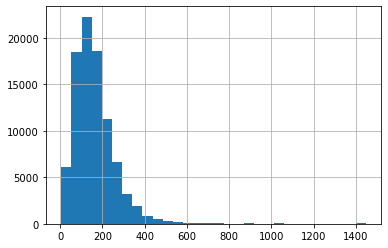

In [59]:
sentences = [len(sent) for sent in data1['text']]
pd.Series(sentences).hist(bins=30)

## RoBERTa Model 

In [60]:
warnings.simplefilter('ignore')
logging.basicConfig(level=logging.ERROR)

In [61]:
from transformers import RobertaTokenizer
#from transformers import BertTokenizer

In [62]:
import cv2
cv2.__version__

'4.5.1'

In [63]:
MAX_LEN = 200 #300(depends)
TRAIN_BATCH_SIZE = 64
TEST_BATCH_SIZE  = 64
VALID_BATCH_SIZE = 64
LEARNING_RATE = 2e-5
tokenizer = RobertaTokenizer.from_pretrained('roberta-base', truncation=True, do_lower_case=True)

In [64]:
from torch.utils.data import Dataset


class MultiLabelDataset(Dataset):
    def __init__(self, dataframe, tokenizer, max_len):
        self.len = len(dataframe)
        self.data = dataframe
        self.text = dataframe.text
        self.targets = dataframe.labels
        self.tokenizer = tokenizer
        self.max_len = max_len
    
    def __len__(self):
        return self.len
        
    def __getitem__(self, index):
        text = str(self.text[index])
        text = " ".join(text.split())
        inputs = self.tokenizer.encode_plus(
            text,
            None,
            add_special_tokens=True,
            max_length=self.max_len,
            pad_to_max_length=True,
            return_token_type_ids=True,
            truncation=True
        )
        ids = inputs['input_ids']
        mask = inputs['attention_mask']
        token_type_ids = inputs["token_type_ids"]

        return {
            'ids': torch.tensor(ids, dtype=torch.long),
            'mask': torch.tensor(mask, dtype=torch.long),
            'token_type_ids': torch.tensor(token_type_ids, dtype=torch.long),
            'targets': torch.tensor(self.targets[index], dtype=torch.long)
        } 

In [65]:
train_size = 0.75
test_size  = 0.60
train_data = data1.sample(frac=train_size,random_state=200)
eval_data  = data1.drop(train_data.index)#.reset_index(drop=True)
test_data  = eval_data.sample(frac=test_size,random_state=200)
val_data   = eval_data.drop(test_data.index)

train_data = train_data.reset_index(drop=True)
test_data  = test_data.reset_index(drop=True)
val_data   = val_data.reset_index(drop=True)



print("FULL Dataset: {}".format(data1.shape))
print("TRAIN Dataset: {}".format(train_data.shape))
print("TEST Dataset: {}".format(test_data.shape))
print("VALIDATION Dataset: {}".format(val_data.shape))

training_set   = MultiLabelDataset(train_data, tokenizer, MAX_LEN)
testing_set    = MultiLabelDataset(test_data, tokenizer, MAX_LEN)
validating_set = MultiLabelDataset(val_data, tokenizer, MAX_LEN)

#train_size = 0.8
#train_data=new_data.sample(frac=train_size,random_state=200)
#test_data=new_data.drop(train_data.index).reset_index(drop=True)
#train_data = train_data.reset_index(drop=True)
#val_data = eval_data1
#
#print("FULL Dataset: {}".format(new_data.shape))
#print("TRAIN Dataset: {}".format(train_data.shape))
#print("TEST Dataset: {}".format(test_data.shape))
#print("Val Dataset: {}".format(val_data.shape))
#
#training_set = MultiLabelDataset(train_data, tokenizer, MAX_LEN)
#testing_set = MultiLabelDataset(test_data, tokenizer, MAX_LEN)
#validation_set = MultiLabelDataset(val_data, tokenizer, MAX_LEN)

FULL Dataset: (90968, 2)
TRAIN Dataset: (68226, 2)
TEST Dataset: (13645, 2)
VALIDATION Dataset: (9097, 2)


In [66]:
train_data['text'][0]

'I doubt, for example, that, 3 months before the leadership began to talk about what came to be the Marshall plan, any public-opinion expert would have said that the country would have accepted such proposals.'

In [69]:
from torch.utils.data import DataLoader

train_params = {'batch_size': TRAIN_BATCH_SIZE,
                'shuffle': True,
                'num_workers': 0
                }

test_params = {'batch_size': TEST_BATCH_SIZE,
                'shuffle': True,
                'num_workers': 0
                }

val_params = {'batch_size': VALID_BATCH_SIZE,
                'shuffle': True,
                'num_workers': 0
                }

training_loader = DataLoader(training_set, **train_params)
testing_loader = DataLoader(testing_set, **test_params)
validating_loader = DataLoader(validating_set, **test_params)

In [70]:
#from transformers import DistilBertModel

#class DistilBERTClass(torch.nn.Module):
#    def __init__(self):
#        super(DistilBERTClass, self).__init__()
#        self.l1 = DistilBertModel.from_pretrained("distilbert-base-uncased")
#        self.pre_classifier = torch.nn.Linear(768, 768)
#        self.dropout = torch.nn.Dropout(0.1)
#        self.classifier = torch.nn.Linear(768, 16356) # 33264
#
#    def forward(self, input_ids, attention_mask, token_type_ids):
#        output_1 = self.l1(input_ids=input_ids, attention_mask=attention_mask)
#        hidden_state = output_1[0]
#        pooler = hidden_state[:, 0]
#        pooler = self.pre_classifier(pooler)
#        pooler = torch.nn.ReLU()(pooler)
#        pooler = self.dropout(pooler)
#        output = self.classifier(pooler)
#        return output
#
#model = DistilBERTClass()
#model.to(device)

from transformers import RobertaModel

class RoBERTaClass(torch.nn.Module):
    def __init__(self):
        super(RoBERTaClass, self).__init__()
        self.l1 = RobertaModel.from_pretrained("roberta-base")
        self.pre_classifier = torch.nn.Linear(768, 768)
        self.dropout = torch.nn.Dropout(0.5)
        #self.classifier_hid = torch.nn.Linear(768, 1512)
        #self.dropout = torch.nn.Dropout(0.5)
        self.classifier = torch.nn.Linear(768, 16356)

    def forward(self, input_ids, attention_mask, token_type_ids):
        output_1 = self.l1(input_ids=input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids)
        hidden_state = output_1[0]
        pooler = hidden_state[:, 0]
        pooler = self.pre_classifier(pooler)
        pooler = torch.nn.ReLU()(pooler)
        pooler = self.dropout(pooler)
        #pooler = self.classifier_hid(pooler)
        #pooler = self.dropout(pooler)
        #pooler = torch.nn.ReLU()(pooler)
        output = self.classifier(pooler)
        return output

model = RoBERTaClass()
model.to(device)

RoBERTaClass(
  (l1): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0): RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), e

In [71]:
def train_epoch(model, data_loader, loss_fn, optimizer, device, scheduler, n_examples): #scheduler,
    model = model.train() 
    losses = []
    correct_predictions = 0
    
    for _,data in enumerate(data_loader, 0):
        ids = data['ids'].to(device, dtype = torch.long)
        mask = data['mask'].to(device, dtype = torch.long)
        token_type_ids = data['token_type_ids'].to(device, dtype = torch.long)
        targets = data['targets'].to(device, dtype = torch.long)
        
        outputs = model(ids, mask, token_type_ids)
        
        _, preds = torch.max(outputs.data, dim=1) #max
        loss = loss_fn(outputs, targets) # get loss
        
        correct_predictions += torch.sum(preds==targets)
        losses.append(loss.item())
        
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
    
    scheduler.step()
    
    return correct_predictions.double() / n_examples, np.mean(losses)

def eval_model(model, data_loader, loss_fn, device, n_examples):
    model = model.eval() #Evaluation mode
    
    losses = []
    correct_predictions = 0
    
    with torch.no_grad():
        for _,data in enumerate(data_loader, 0):
            ids = data['ids'].to(device, dtype = torch.long)
            mask = data['mask'].to(device, dtype = torch.long)
            token_type_ids = data['token_type_ids'].to(device, dtype = torch.long)
            targets = data['targets'].to(device, dtype = torch.long)
            
            outputs = model(ids, mask, token_type_ids)
            
            _, preds = torch.max(outputs.data, dim=1)
            
            loss = loss_fn(outputs, targets)
            
            correct_predictions += torch.sum(preds==targets)
            losses.append(loss.item())
            
    return correct_predictions.double() / n_examples, np.mean(losses) 

In [72]:
import shutil
from collections import defaultdict

def train_model(model, data_loaders_train, data_loader_test, train_sizes, test_sizes, device, n_epochs):
    optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.001)
    loss_fn   = torch.nn.CrossEntropyLoss().to(device)
    
    history = defaultdict(list)
    best_accuracy = 0
    
    for epoch in range(n_epochs):
        print(f'Epoch {epoch + 1}/{n_epochs}')
        print('-' * 10)
        
        train_acc, train_loss = train_epoch(model, training_loader, loss_fn, 
                                            optimizer, device, scheduler, train_data.shape[0]) #scheduler,
        
        print(f'Train loss {train_loss}, accuracy {train_acc}') #accuracy {train_acc}
        
        val_acc, val_loss = eval_model(model, testing_loader, loss_fn, device, test_data.shape[0])
        
        print(f'Val loss {val_loss}, accuracy {val_acc}') # accuracy {val_acc}
        print()
        
        history['train_acc'].append(train_acc)
        history['train_loss'].append(train_loss)
        history['val_acc'].append(val_acc)
        history['val_loss'].append(val_loss)
        
        if val_acc > best_accuracy:
            torch.save(model.state_dict(), 'best_model_state.bin')
            best_accuracy = val_acc
            
    print(f'Best val accuracy: {best_accuracy}')
    
    model.load_state_dict(torch.load('best_model_state.bin'))
    
    return model, history

In [73]:
%%time

base_model, history = train_model(model, training_loader, testing_loader, train_data.shape[0], test_data.shape[0],
                                  device, n_epochs=20)

Epoch 1/20
----------
Train loss 8.565107792923131, accuracy 0.07734587986984434
Val loss 8.120883685406124, accuracy 0.08581898131183584

Epoch 2/20
----------
Train loss 7.806189047698116, accuracy 0.09461202474130098
Val loss 7.795162735698379, accuracy 0.10150238182484426

Epoch 3/20
----------
Train loss 7.375795157914309, accuracy 0.10709993257702342
Val loss 7.65663963834816, accuracy 0.11037009893733969

Epoch 4/20
----------
Train loss 7.08048688572148, accuracy 0.11706680737548736
Val loss 7.65166648526058, accuracy 0.114034444851594

Epoch 5/20
----------
Train loss 6.841111362818367, accuracy 0.12536276492832646
Val loss 7.5831114555073675, accuracy 0.11901795529497985

Epoch 6/20
----------
Train loss 6.667361547707841, accuracy 0.13251546331310646
Val loss 7.606081755361824, accuracy 0.11945767680469037

Epoch 7/20
----------
Train loss 6.660278977695311, accuracy 0.13384926567584207
Val loss 7.614751940575715, accuracy 0.11953096372297546

Epoch 8/20
----------
Train los

In [74]:
import PIL.Image as Image
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from matplotlib.ticker import MaxNLocator

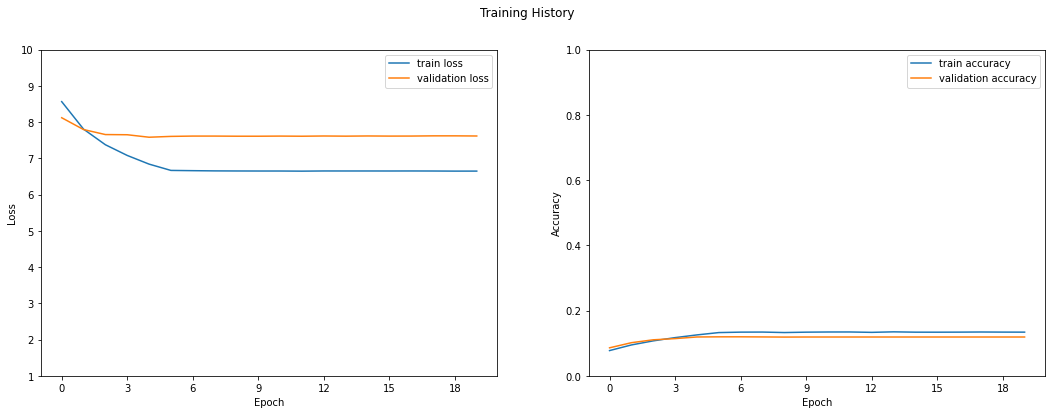

In [76]:
def plot_training_history(history):
    fig, (ax1, ax2) = plt.subplots(1,2, figsize=(18,6))
    ax1.plot(history['train_loss'], label='train loss')
    ax1.plot(history['val_loss'], label='validation loss')
    
    ax1.xaxis.set_major_locator(MaxNLocator(integer=True))
    ax1.set_ylim([1.00,10.00])
    ax1.legend()
    ax1.set_ylabel('Loss')
    ax1.set_xlabel('Epoch')
    
    ax2.plot(history['train_acc'], label='train accuracy')
    ax2.plot(history['val_acc'], label='validation accuracy')
    
    ax2.xaxis.set_major_locator(MaxNLocator(integer=True))
    ax2.set_ylim([0.00,1.00])
    ax2.legend()
    ax2.set_ylabel('Accuracy')
    ax2.set_xlabel('Epoch')
    
    fig.suptitle('Training History')
    
plot_training_history(history)

In [77]:
from sklearn.metrics import confusion_matrix, classification_report

In [78]:
def get_predictions(model, data_loader):
    model = model.eval()
    predictions = []
    real_values = []
    with torch.no_grad():
        for _,data in enumerate(data_loader, 0):
            ids = data['ids'].to(device, dtype = torch.long)
            mask = data['mask'].to(device, dtype = torch.long)
            token_type_ids = data['token_type_ids'].to(device, dtype = torch.long)
            targets = data['targets'].to(device, dtype = torch.long)
            
            outputs = model(ids, mask, token_type_ids)
            
            _, preds = torch.max(outputs.data, 1)
            predictions.extend(preds)
            real_values.extend(targets)
    predictions = torch.as_tensor(predictions).cpu()
    real_values = torch.as_tensor(real_values).cpu()
    
    return predictions, real_values

y_pred, y_test = get_predictions(model, validating_loader)

In [79]:
print(classification_report(y_test, y_pred)) #, target_names=class_names

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         3
           1       0.00      0.00      0.00         1
           3       0.00      0.00      0.00         3
           5       0.00      0.00      0.00         1
           6       0.00      0.00      0.00         1
           8       0.00      0.00      0.00         1
          16       0.00      0.00      0.00         1
          21       0.00      0.00      0.00         1
          22       0.00      0.00      0.00         1
          24       0.00      0.00      0.00         1
          27       0.00      0.00      0.00         3
          28       0.00      0.00      0.00         1
          29       0.00      0.00      0.00         4
          35       0.00      0.00      0.00         1
          38       0.00      0.00      0.00         1
          42       0.00      0.00      0.00         1
          44       0.00      0.00      0.00         1
          48       0.00    